In [80]:
import pandas as pd
from rake_nltk import Rake
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [81]:
sentiment_df = pd.read_csv('userSentiment.csv')
sentiment_df

,user_id,user_name,status
0,50393960,BillGates,positive


In [82]:
films_df = pd.read_csv('https://query.data.world/s/uikepcpffyo2nhig52xxeevdialfl7')

films_df = films_df[['Title','Genre','Director','Actors','Plot']]
films_df.head()

,Title,Genre,Director,Actors,Plot
0,The Shawshank Redemption,"Crime, Drama",Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Two imprisoned men bond over a number of years...
1,The Godfather,"Crime, Drama",Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Richard ...",The aging patriarch of an organized crime dyna...
2,The Godfather: Part II,"Crime, Drama",Francis Ford Coppola,"Al Pacino, Robert Duvall, Diane Keaton, Robert...",The early life and career of Vito Corleone in ...
3,The Dark Knight,"Action, Crime, Drama",Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",When the menace known as the Joker emerges fro...
4,12 Angry Men,"Crime, Drama",Sidney Lumet,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",A jury holdout attempts to prevent a miscarria...


In [83]:
# discarding the commas between the actors' full names and getting only the first three names
films_df['Actors'] = films_df['Actors'].map(lambda x: x.split(',')[:3])

# putting the genres in a list of words
films_df['Genre'] = films_df['Genre'].map(lambda x: x.lower().split(','))

films_df['Director'] = films_df['Director'].map(lambda x: x.split(' '))

# merging together first and last name for each actor and director, so it's considered as one word 
# and there is no mix up between people sharing a first name
for index, row in films_df.iterrows():
    row['Actors'] = [x.lower().replace(' ','') for x in row['Actors']]
    row['Director'] = ''.join(row['Director']).lower()

In [84]:
# initializing the new column
films_df['Key_words'] = ""

for index, row in films_df.iterrows():
    plot = row['Plot']
    
    # instantiating Rake, by default is uses english stopwords from NLTK
    # and discard all puntuation characters
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)

    # getting the dictionary whith key words and their scores
    key_words_dict_scores = r.get_word_degrees()
    
    # assigning the key words to the new column
    row['Key_words'] = list(key_words_dict_scores.keys())

# dropping the Plot column
films_df.drop(columns = ['Plot'], inplace = True)

In [85]:
films_df.set_index('Title', inplace = True)
films_df.head()

,Genre,Director,Actors,Key_words
Title,,,,
The Shawshank Redemption,"[crime, drama]",frankdarabont,"[timrobbins, morganfreeman, bobgunton]","[two, imprisoned, men, bond, eventual, redempt..."
The Godfather,"[crime, drama]",francisfordcoppola,"[marlonbrando, alpacino, jamescaan]","[aging, patriarch, reluctant, son, clandestine..."
The Godfather: Part II,"[crime, drama]",francisfordcoppola,"[alpacino, robertduvall, dianekeaton]","[portrayed, early, life, son, expands, tighten..."
The Dark Knight,"[action, crime, drama]",christophernolan,"[christianbale, heathledger, aaroneckhart]","[fight, injustice, physical, tests, mysterious..."
12 Angry Men,"[crime, drama]",sidneylumet,"[martinbalsam, johnfiedler, leej.cobb]","[prevent, jury, holdout, attempts, colleagues,..."


In [88]:
films_df['bag_of_words'] = ''
columns = films_df.columns
for index, row in films_df.iterrows():
    words = ''
    for col in columns:
        if col != 'Director':
            words = words + ' '.join(row[col])+ ' '
        else:
            words = words + row[col]+ ' '
    row['bag_of_words'] = words
    
films_df.drop(columns = [col for col in films_df.columns if col!= 'bag_of_words'], inplace = True)

films_df.head()

,bag_of_words
Title,
The Shawshank Redemption,crime drama frankdarabont timrobbins morganfr...
The Godfather,crime drama francisfordcoppola marlonbrando a...
The Godfather: Part II,crime drama francisfordcoppola alpacino rober...
The Dark Knight,action crime drama christophernolan christia...
12 Angry Men,crime drama sidneylumet martinbalsam johnfied...


In [90]:
# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(films_df['bag_of_words'])

# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

cosine_sim

array([[1.        , 0.15789474, 0.13764944, ..., 0.05263158, 0.05263158,
        0.05564149],
       [0.15789474, 1.        , 0.36706517, ..., 0.05263158, 0.05263158,
        0.05564149],
       [0.13764944, 0.36706517, 1.        , ..., 0.04588315, 0.04588315,
        0.04850713],
       ...,
       [0.05263158, 0.05263158, 0.04588315, ..., 1.        , 0.05263158,
        0.05564149],
       [0.05263158, 0.05263158, 0.04588315, ..., 0.05263158, 1.        ,
        0.05564149],
       [0.05564149, 0.05564149, 0.04850713, ..., 0.05564149, 0.05564149,
        1.        ]])

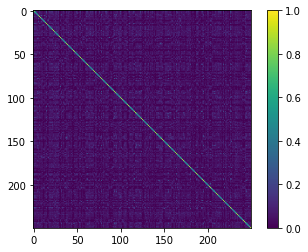

In [91]:
plt.imshow(cosine_sim)
plt.colorbar()
plt.show()

In [94]:
# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(films_df.index)
indices[:5]

# function that takes in movie title as input and returns the top 10 recommended movies
def recommendations(title, cosine_sim = cosine_sim):
    
    recommended_movies = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(films_df.index)[i])
        
    return recommended_movies

In [96]:
recommendations('Fargo')

['No Country for Old Men',
 'The Departed',
 'Rope',
 'The Godfather',
 'Reservoir Dogs',
 'The Godfather: Part II',
 'On the Waterfront',
 'Goodfellas',
 'Arsenic and Old Lace',
 'The Big Lebowski']